In [23]:
import train
import bow
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score


f=pd.read_csv('all-data.csv',names=['sentiment','feedback'],encoding_errors='ignore')
texts=f['feedback'].values
obj=train.ModelTrainer()
vect=bow.FeatureExtractor()
x=vect.fit_transform_tfidf(train.punc(f['feedback'].to_numpy()))[0]
y=f['sentiment'].apply(train.decode).to_numpy()
x_train,x_test,y_train,y_test,text_train,text_test=train_test_split(x,y,texts,test_size=0.3,stratify=y)


In [6]:
obj.train_logistic_regression(x_train,y_train,x_test,y_test)
print("logistic_regression trained")
obj.train_naive_bayes(x_train,y_train,x_test,y_test)
print("naive_bayes trained")
obj.train_knn(x_train,y_train,x_test,y_test)
print("knn trained")
results=obj.compare_models()['accuracy']
best=results.idxmax()
obj.best_model=obj.models[best]

C:\Users\dhrub\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dhrub\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dhrub\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dhrub\AppDa

logistic_regression trained
naive_bayes trained
knn trained


In [7]:
best_model=obj.best_model
y_pred=best_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision_per_class = precision_score(y_test, y_pred, average=None)
recall_per_class = recall_score(y_test, y_pred, average=None)
f1_per_class = f1_score(y_test, y_pred, average=None)
cm = confusion_matrix(y_test, y_pred)
report=pd.DataFrame({'accuracy':accuracy,'precision':precision_per_class,'recall':recall_per_class,'f1':f1_per_class},index=['negative','positive','neutral'])
print('report for entire test data')
print(report)
print("Confusion matrix:")
print(cm)

report for entire test data
          accuracy  precision    recall        f1
negative  0.762036   0.811321  0.475138  0.599303
positive  0.762036   0.721362  0.569682  0.636612
neutral   0.762036   0.769756  0.913194  0.835363
Confusion matrix:
[[ 86  26  69]
 [  9 233 167]
 [ 11  64 789]]


In [8]:
scores = cross_val_score(best_model, x_train, y_train, cv=5, scoring='f1_weighted')
print(f"CV Scores: {scores}")
print(f"Mean: {scores.mean():.3f} ± {scores.std():.3f}")


CV Scores: [0.73116191 0.76790103 0.72613532 0.73237087 0.74758938]
Mean: 0.741 ± 0.015


In [9]:
scores = cross_val_score(best_model, x_train, y_train, cv=5, scoring='accuracy')
print(f"CV Scores: {scores}")
print(f"Mean: {scores.mean():.3f} ± {scores.std():.3f}")


CV Scores: [0.7466863  0.77908689 0.74336283 0.74778761 0.76253687]
Mean: 0.756 ± 0.013


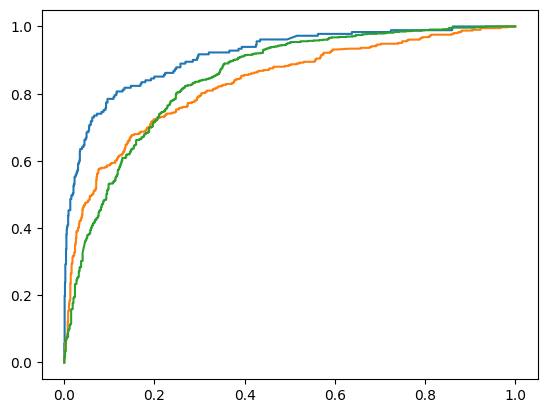

In [10]:
for class_label in [0, 1, 2]:  # positive, negative, neutral
    y_true_binary = (y_test == class_label).astype(int)
    y_pred_proba = best_model.predict_proba(x_test)[:, class_label]
    
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_proba)
    roc_auc = roc_auc_score(y_true_binary, y_pred_proba)
    
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC={roc_auc:.3f})')


Text(0.5, 1.0, 'Precision-Recall Curve')

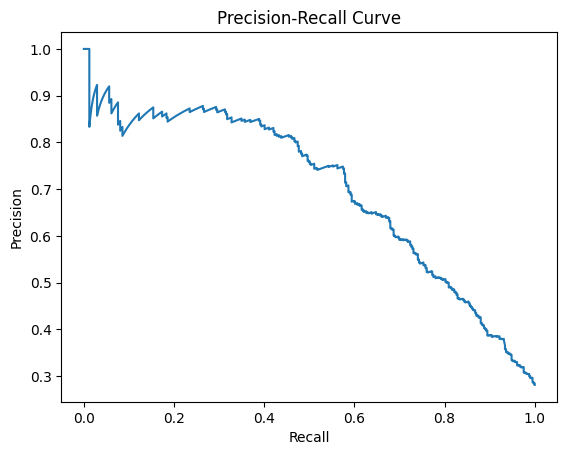

In [11]:
from sklearn.metrics import precision_recall_curve

y_true_binary = (y_test == 1).astype(int)  # Example: positive class
y_pred_proba = best_model.predict_proba(x_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_true_binary, y_pred_proba)

plt.plot(recall, precision)
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

In [12]:
prob=best_model.predict_proba(x_test)

In [13]:
def score(x):
    return max(prob[x])

In [14]:
temp=np.where(y_pred != y_test)[0]
misclassified_indices = sorted(temp,key=score)

# Get top 5 with highest confidence (but wrong prediction)
top_misclassified = misclassified_indices[-5:]
analysis=['the entire sentence is positive all because of the \'optimisic\' but its score is determined by its frequency not its actions and it is probably a common word and gets ignored and hence neutral',
         'The sentence looks like positive so If I were to tag it, even I would also mark it positive as the system',
         'The model has no direct way to have a sense of numbers. Here 37 is a big enough number so it is positive but that 37 can\'t make a difference in the model because its meaning is based on its frequency only',
         'Most probably, the word \'awarded\' made the difference though the semantic meaning out here is very different and not positive',
         'Maybe the words like acquired and agreement appears frequently so it is marking it as positive but the semantic meaning was different']
c=0
for idx in top_misclassified:
    text = text_test[idx]  # Need to keep original text
    predicted = y_pred[idx]
    actual = y_test[idx]
    confidence = max(best_model.predict_proba(x_test)[idx])
    
    print(f"Text: {text}")
    print(f"Predicted: {predicted}, Actual: {actual}, Confidence: {confidence:.2f}")
    print(f"Why did model fail?\n{analysis[c]}")
    c+=1

    
plt.show()

Text: The Finnish company Stockmann has signed the contract with the company Technopolis .
Predicted: 1, Actual: 2, Confidence: 0.97
Why did model fail?
the entire sentence is positive all because of the 'optimisic' but its score is determined by its frequency not its actions and it is probably a common word and gets ignored and hence neutral
Text: At first the contract envisaged the construction of three ferryboats with an option for two more units , further confirmed at a total value of 500 mln euro ( $ 645.8 mln ) .
Predicted: 2, Actual: 1, Confidence: 0.98
Why did model fail?
The sentence looks like positive so If I were to tag it, even I would also mark it positive as the system
Text: Following the transaction , Lundbeck has worldwide rights for nalmefene , excluding North America , Mexico , Turkey and South-Korea .
Predicted: 2, Actual: 1, Confidence: 0.99
Why did model fail?
The model has no direct way to have a sense of numbers. Here 37 is a big enough number so it is positive 

In [15]:
x1,x_test1,y1,y_test1,text1,text_test1=train_test_split(x_test,y_test,text_test,test_size=0.15,stratify=y_test)


In [22]:
#best_model=obj.best_model
y_pred=best_model.predict(x_test1)
accuracy = accuracy_score(y_test1, y_pred)
precision_per_class = precision_score(y_test1, y_pred, average=None)
recall_per_class = recall_score(y_test1, y_pred, average=None)
f1_per_class = f1_score(y_test1, y_pred, average=None)
cm = confusion_matrix(y_test1, y_pred)
report=pd.DataFrame({'accuracy':accuracy,'precision':precision_per_class,'recall':recall_per_class,'f1':f1_per_class},index=['negative','positive','neutral'])
print(report)
print("Confusion matrix:")
print(cm)

          accuracy  precision    recall        f1
negative  0.753425   0.800000  0.444444  0.571429
positive  0.753425   0.711538  0.596774  0.649123
neutral   0.753425   0.763158  0.892308  0.822695
Confusion matrix:
[[ 12   2  13]
 [  2  37  23]
 [  1  13 116]]


In [52]:
#you can play around here with the trained model. Giving any sentence you want. However this is to be noted that 
#the dataset was small just about 5000 data so the vocabulary is also small and if any words are OOV then most likely it will output neutral
text=['Finland \'s Nokian Tyres and Kazakhstan \'s Ordabasy Corporation signed an agreement to build a plant in Astana to produce car tires , Ordabasy chairman Dinmukhamet Idrisov said at a press conference .']

In [53]:
x=vect.tfidf_vectorizer.transform(train.punc(text))[0]
y=best_model.predict(x)
res='negative' if y==0 else 'neutral' if y==2 else 'positive'
print(res)

positive
